The MedMNIST dataset is licensed under Creative Commons Attribution 4.0 International (CC BY 4.0). The dataset is from the following paper:

* Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification". arXiv preprint arXiv:2110.14795, 2021.
* Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th International Symposium on Biomedical Imaging (ISBI), 2021.

The MedMNIST dataset contains medical imaging data ranging from colonoscopy imaging to abdominal CT scans to breast ultrasounds.  There two main types of data formats that are used: 2 dimensional images and 3 dimensional.  In this notebook, we will explore the Chest X-Ray data within the MedMNIST dataset:

**Required packages**

In [ ]:
# medmnist installation
# Terminal command for installing packages. pip is commonly used to install any python package.  Here, we pass in medmnist as the package name.  You can install any existing python packages using the command format pip install XXX, where XXX is the name of the desired package.
! pip install medmnist
! pip install keras

# keras imports
from keras import layers
from keras import models
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import torchvision.transforms as transforms

# utlity packages
from PIL import Image
import numpy as np
import random


import medmnist
from medmnist import INFO, Evaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 4.3 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=355a9a769b19255f45bb2559647f2db083467f1bb72765b3efa3b86aede94a76
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Loading in the Dataset**

In [ ]:
# Helper function for rretrieving the dataset
def get_loader(dataset, batch_size):
    total_size = len(dataset)
    print('Size', total_size)
    index_generator = shuffle_iterator(range(total_size))
    while True:
        data = []
        for _ in range(batch_size):
            idx = next(index_generator)
            data.append(dataset[idx])
        yield dataset._collate_fn(data)

# This function takes in an iterator and shuffles the order of the items in it
def shuffle_iterator(iterator):
    # iterator should have limited size
    index = list(iterator)
    total_size = len(index)
    i = 0
    random.shuffle(index)
    while True:
        yield index[i]
        i += 1
        if i >= total_size:
            i = 0
            random.shuffle(index)
  
# There are a lot of different dataset.  The data_flag field is that specifies which dataset we are going to be pulling from.  The other parameters are self explanatory.
data_flag = 'pathmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# This transforms our data through tensor building and normalization.
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# In these lines we split the dataset into training and testing data for future use.  These are all objects in the form of a python class.
train_loader = get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = get_loader(dataset=test_dataset, batch_size=BATCH_SIZE)

print(train_dataset)

# Splitting the dataset into images and labels using numpy and list comprehensions
training_images = np.array([np.array(elem[0]) for elem in train_dataset])
training_labels = np.array([np.array(elem[1]) for elem in train_dataset])
testing_images = np.array([np.array(elem[0]) for elem in test_dataset])
testing_labels = np.array([np.array(elem[1]) for elem in test_dataset])

  0%|          | 0/205615438 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulti

You don't need to worry about understanding the functions get_loader and shuffle_iterator (those are for simply loading in the data from MedMNIST).  If you want to laern more about the dataset itself as well as the code and paper you can visit the MedMNIst website at https://medmnist.com/.  The above code segment prints the summary of the training dataset and separates the datasets into the respective images and labels.  We will look into the images and labels in more detail.

Task: get a summary of the testing dataset (hint. look how we printed the training dataset summary above)

Let's now take a look at inidividual pictures.  We can look at the images with and without colors.  You can edit the parameter length to display however many images you want.  For example, if you wanted to see five images you can change it to train_dataset.montage(length=5).  Feel free to play around with this to see what the actual images look like

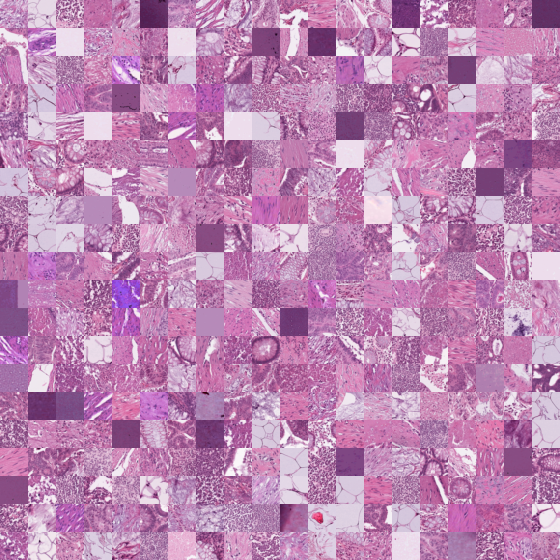

In [ ]:
# The .montage() function takes in a parameter length which allows you to set the number of images per row and per column to output in a square montage.  
# This function is specific to the DataClass class.  In this example, we have set the parameter length to 20, and we can count 20 images as the side length of the square montage.
train_dataset.montage(length=20)


These images are the grayscale images.  Similar to above, you can set i to whatever image to see what it looks like.  i represents the index of the image in the dataset.  This means if i is 3, then the image displayed will be the 3rd image in the dataset

label: [5]


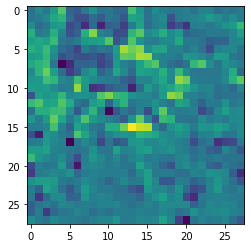

In [ ]:
# Look at one image
from matplotlib import pyplot as plt

i=300

print('label: ' + str(training_labels[i]))
# imshow can take in an image in array format
plt.imshow(training_images[i][1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


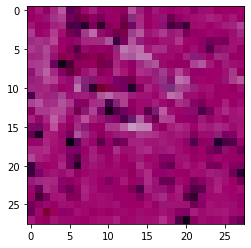

In [ ]:
from PIL import Image

# Creating a single image and putting it in a 3D array format for viewing
single_image = []
for j in range(28):
  tmp = []
  for k in range(28):
    tmp.append((training_images[i][0][j][k], training_images[i][1][j][k], training_images[i][2][j][k]))
  single_image.append(tmp)

# Plotting
plt.imshow(single_image)
plt.show()

Now, let's look at the labels of these images. Printing the dataset will give us an overview of what the labels are and what they mean.

In [ ]:
# Printing out the summary of the dataset and viewing the labels in number format
print(train_dataset)
labels = [item[0] for item in training_labels]
print(labels)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into train

Fill out the following dictionary. (hint. follow the same format as the first example and look at the labels from the printed dataset above)

In [ ]:
# Manually created a dictionary to map each label to the number of times it appeared in the dataset.  
# The left side is the label and the right is the count
number_classes = {
  'adipose': labels.count(0),
  'background': labels.count(1),
  'debris': labels.count(2),
  'lymphocytes': labels.count(3),
  'mucus': labels.count(4),
  'smooth muscle': labels.count(5),
  'normal colon mucosa': labels.count(6),
  'cancer-associated stroma': labels.count(7),
  'colorectal adenocarcinoma epithelium': labels.count(8),
}


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

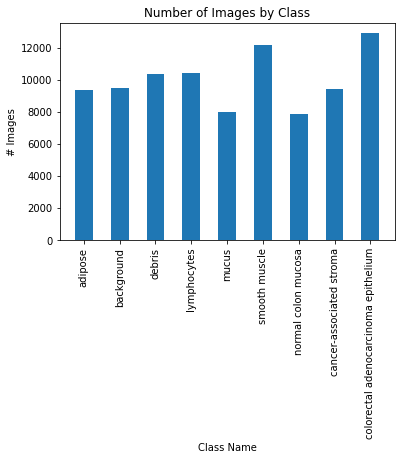

In [ ]:
# Creating the bar chart and adding the correct labels.  The functions used here correspond to each part of the graph
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');
plt.xticks(rotation='vertical')